In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import shutil
import zipfile
import os
import requests
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [6]:
!kaggle datasets download alphiree/cardiovascular-diseases-risk-prediction-dataset

 62%|███████████████████████▍              | 3.00M/4.87M [00:00<00:00, 6.60MB/s]
100%|██████████████████████████████████████| 4.87M/4.87M [00:00<00:00, 8.23MB/s]


In [7]:
!kaggle datasets download sulianova/cardiovascular-disease-dataset

100%|████████████████████████████████████████| 742k/742k [00:00<00:00, 1.74MB/s]
100%|████████████████████████████████████████| 742k/742k [00:00<00:00, 1.73MB/s]


In [8]:
# Nombre del archivo ZIP que deseas mover, extraer y eliminar
archivos_zip = ["cardiovascular-diseases-risk-prediction-dataset.zip", "cardiovascular-disease-dataset.zip"]
for archivo_zip in archivos_zip:
    # Ruta del archivo ZIP actual
    ruta_zip = os.path.abspath(archivo_zip)

    # Ruta de la carpeta de destino
    carpeta_destino = "Datasets"

    # Mover el archivo ZIP a la carpeta de destino
    shutil.move(ruta_zip, os.path.join(carpeta_destino, archivo_zip))

    # Ruta completa del archivo ZIP en la carpeta de destino
    ruta_zip_destino = os.path.join(carpeta_destino, archivo_zip)

    # Descomprimir el archivo ZIP en la carpeta de destino
    with zipfile.ZipFile(ruta_zip_destino, 'r') as zip_ref:
        zip_ref.extractall(carpeta_destino)

    # Eliminar el archivo ZIP
    os.remove(ruta_zip_destino)

    print(f"Archivo {archivo_zip} movido, extraído y eliminado.")


Archivo cardiovascular-diseases-risk-prediction-dataset.zip movido, extraído y eliminado.
Archivo cardiovascular-disease-dataset.zip movido, extraído y eliminado.


# Cargar y preprocesar los datos

In [43]:
# Carga el archivo CSV en un DataFrame de pandas
data = pd.read_csv('Datasets/CVD_cleaned.csv', sep=',')
data2 = pd.read_csv('Datasets/cardio_train.csv', sep=';')
columnas_1 = data.columns
columnas_2 = data2.columns

In [44]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [45]:
data2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [46]:
print(columnas_1)

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')


In [47]:
data.columns = ['Salud_General', 'Chequeo', 'Ejercicio', 'Enfermedad_Cardíaca', 'Cáncer_de_Piel',
'Otros_Cánceres', 'Depresión', 'Diabetes', 'Artritis', 'Sexo',
'Categoría_de_Edad', 'Altura_(cm)', 'Peso_(kg)', 'IMC', 'Historial_de_Tabaco',
'Consumo_de_Alcohol', 'Consumo_de_Frutas',
'Consumo_de_Vegetales_Verdes', 'Consumo_de_Papas_Fritas']


In [48]:
data["Consumo_de_Alcohol"] = data["Consumo_de_Alcohol"].apply(lambda x: 1 if x > 15 else 0)
data["Historial_de_Tabaco"] = data["Historial_de_Tabaco"].replace({'Yes':1, 'No':0})
data["Sexo"] = data["Sexo"].replace({'Male':1, 'Female':2})
data["Enfermedad_Cardíaca"] = data["Enfermedad_Cardíaca"].replace({'Yes':1, 'No':0})
data["Ejercicio"] = data["Ejercicio"].replace({'Yes':1, 'No':0})

In [49]:
data2.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [50]:
data2.columns = ['id', 'Categoría_de_Edad', 'Sexo', 'Altura_(cm)', 'Peso_(kg)', 'ap_hi', 'ap_lo',
                      'colesterol', 'glucosa', 'Historial_de_Tabaco', 'Consumo_de_Alcohol', 'Ejercicio', 'Enfermedad_Cardíaca']

In [51]:
data.head()

,Salud_General,Chequeo,Ejercicio,Enfermedad_Cardíaca,Cáncer_de_Piel,Otros_Cánceres,Depresión,Diabetes,Artritis,Sexo,Categoría_de_Edad,Altura_(cm),Peso_(kg),IMC,Historial_de_Tabaco,Consumo_de_Alcohol,Consumo_de_Frutas,Consumo_de_Vegetales_Verdes,Consumo_de_Papas_Fritas
0,Poor,Within the past 2 years,0,0,No,No,No,No,Yes,2,70-74,150.0,32.66,14.54,1,0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,No,No,No,Yes,No,2,70-74,165.0,77.11,28.29,0,0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,No,No,No,Yes,No,2,60-64,163.0,88.45,33.47,0,0,12.0,3.0,16.0
3,Poor,Within the past year,1,1,No,No,No,Yes,No,1,75-79,180.0,93.44,28.73,0,0,30.0,30.0,8.0
4,Good,Within the past year,0,0,No,No,No,No,No,1,80+,191.0,88.45,24.37,1,0,8.0,4.0,0.0


In [52]:
data2 = data2.drop(['id', 'Categoría_de_Edad'], axis=1)

In [53]:
column_join = data.columns.intersection(data2.columns)
dataset = pd.concat([data[column_join], data2[column_join]], axis=0)
columnas = dataset.columns

In [54]:
dataset

,Ejercicio,Enfermedad_Cardíaca,Sexo,Altura_(cm),Peso_(kg),Historial_de_Tabaco,Consumo_de_Alcohol
0,0,0,2,150.0,32.66,1,0
1,0,1,2,165.0,77.11,0,0
2,1,0,2,163.0,88.45,0,0
3,1,1,1,180.0,93.44,0,0
4,0,0,1,191.0,88.45,1,0
...,...,...,...,...,...,...,...
69995,1,0,2,168.0,76.00,1,0
69996,1,1,1,158.0,126.00,0,0
69997,0,1,2,183.0,105.00,0,1
69998,0,1,1,163.0,72.00,0,0


In [55]:
from sklearn.preprocessing import StandardScaler

columnas = dataset.columns

# Estandarización
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

data_scaled = pd.DataFrame(dataset, columns=columnas)

In [56]:
data_scaled.head()

,Ejercicio,Enfermedad_Cardíaca,Sexo,Altura_(cm),Peso_(kg),Historial_de_Tabaco,Consumo_de_Alcohol
0,-1.884908,-0.433575,1.025458,-1.847378,-2.392181,1.372038,-0.343149
1,-1.884908,2.306404,1.025458,-0.423349,-0.230732,-0.728843,-0.343149
2,0.530530,-0.433575,1.025458,-0.613219,0.320693,-0.728843,-0.343149
3,0.530530,2.306404,-0.975174,1.000681,0.563339,-0.728843,-0.343149
4,-1.884908,-0.433575,-0.975174,2.044969,0.320693,1.372038,-0.343149


In [57]:
corr_mat = data_scaled.corr()

In [58]:
var_obj = data_scaled['Enfermedad_Cardíaca']
data_scaled.drop(columns=['Enfermedad_Cardíaca'], inplace=True)

# Agrega la columna objetivo al final del DataFrame
data_scaled['Enfermedad_Cardíaca'] = var_obj

data_scaled

,Ejercicio,Sexo,Altura_(cm),Peso_(kg),Historial_de_Tabaco,Consumo_de_Alcohol,Enfermedad_Cardíaca
0,-1.884908,1.025458,-1.847378,-2.392181,1.372038,-0.343149,-0.433575
1,-1.884908,1.025458,-0.423349,-0.230732,-0.728843,-0.343149,2.306404
2,0.530530,1.025458,-0.613219,0.320693,-0.728843,-0.343149,-0.433575
3,0.530530,-0.975174,1.000681,0.563339,-0.728843,-0.343149,2.306404
4,-1.884908,-0.975174,2.044969,0.320693,1.372038,-0.343149,-0.433575
...,...,...,...,...,...,...,...
378849,0.530530,1.025458,-0.138543,-0.284708,1.372038,-0.343149,-0.433575
378850,0.530530,-0.975174,-1.087896,2.146619,-0.728843,-0.343149,2.306404
378851,-1.884908,1.025458,1.285487,1.125462,-0.728843,2.914184,2.306404
378852,-1.884908,-0.975174,-0.613219,-0.479214,-0.728843,-0.343149,2.306404


In [59]:
dataset.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

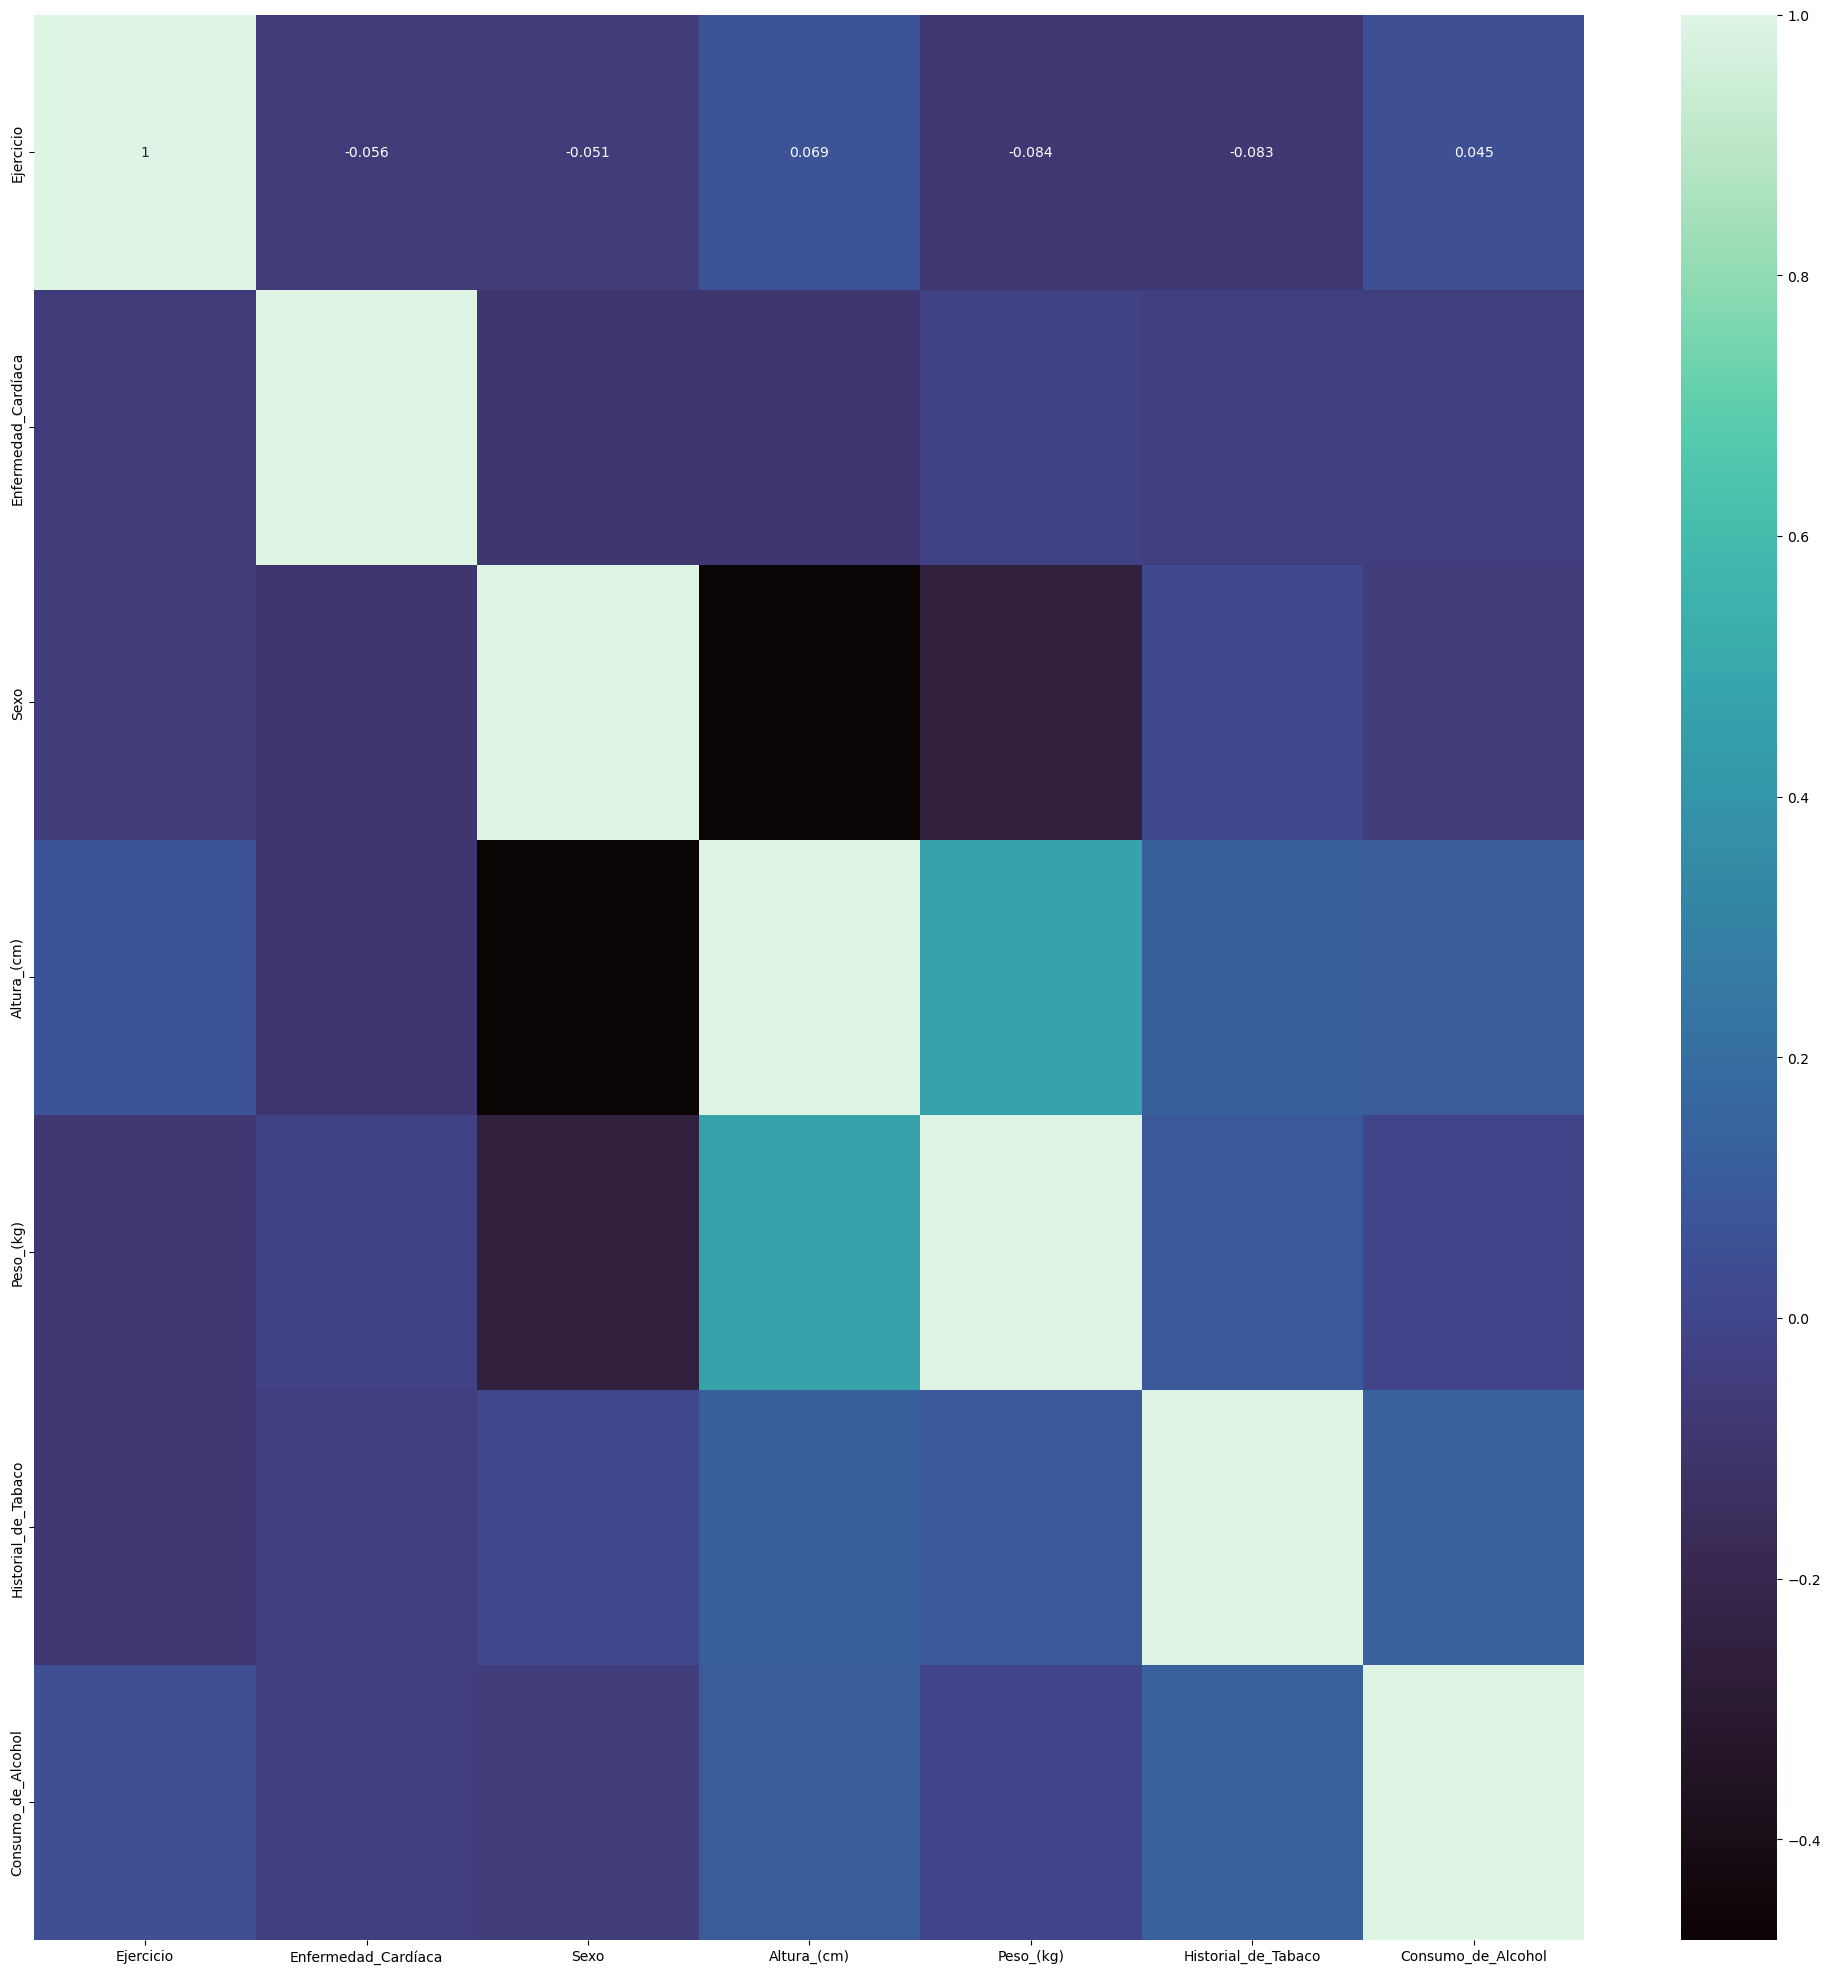

In [60]:
# Plot de matriz de correlación 

plt.figure(figsize=(25,25))
sns.heatmap(data = corr_mat, annot=True, cmap="mako")
plt.show()


In [61]:
correlacion_umbral = 0.005

variables_correlacionadas = set()

# Itera a través de las filas y columnas de la matriz de correlación
for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) >= correlacion_umbral:
            variable1 = corr_mat.columns[i]
            variable2 = corr_mat.columns[j]
            variables_correlacionadas.add((variable1, variable2))
            
variables_correlacionadas


{('Altura_(cm)', 'Ejercicio'),
 ('Altura_(cm)', 'Enfermedad_Cardíaca'),
 ('Altura_(cm)', 'Sexo'),
 ('Consumo_de_Alcohol', 'Altura_(cm)'),
 ('Consumo_de_Alcohol', 'Ejercicio'),
 ('Consumo_de_Alcohol', 'Enfermedad_Cardíaca'),
 ('Consumo_de_Alcohol', 'Historial_de_Tabaco'),
 ('Consumo_de_Alcohol', 'Peso_(kg)'),
 ('Consumo_de_Alcohol', 'Sexo'),
 ('Enfermedad_Cardíaca', 'Ejercicio'),
 ('Historial_de_Tabaco', 'Altura_(cm)'),
 ('Historial_de_Tabaco', 'Ejercicio'),
 ('Historial_de_Tabaco', 'Enfermedad_Cardíaca'),
 ('Historial_de_Tabaco', 'Peso_(kg)'),
 ('Historial_de_Tabaco', 'Sexo'),
 ('Peso_(kg)', 'Altura_(cm)'),
 ('Peso_(kg)', 'Ejercicio'),
 ('Peso_(kg)', 'Enfermedad_Cardíaca'),
 ('Peso_(kg)', 'Sexo'),
 ('Sexo', 'Ejercicio'),
 ('Sexo', 'Enfermedad_Cardíaca')}

In [62]:
#Dividir en set de entrenamiento y set de prueba con las categorías más relacionadas

y = data_scaled['Enfermedad_Cardíaca']
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(data_scaled[['Ejercicio', 'Sexo', 'Altura_(cm)', 'Peso_(kg)',
       'Historial_de_Tabaco', 'Consumo_de_Alcohol']], y, test_size = 0.85, random_state = 85, stratify=y)

y_train = y_train.replace(3, 1)
y_test = y_test.replace(3, 1)

#Let's check the shape of the training and test sets.

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(56828, 6) (56828,) (322026, 6) (322026,)


In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Agrega el modelo SVM
from sklearn.neighbors import KNeighborsClassifier  # Agrega el modelo KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB  # Agrega el modelo Gaussian Naive Bayes
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define los modelos y sus respectivos hiperparámetros
modelos = {
    'Regresión Logística': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'KNeighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
    'Naive Bayes': (GaussianNB(), {}) 
}



In [72]:
resultados = {}

# Define una variable para el mejor modelo KNeighbors
mejor_modelo_kneighbors = None

for nombre_modelo, (modelo, parametros) in tqdm(modelos.items()):
    grid_search = GridSearchCV(modelo, parametros, cv=10, scoring='accuracy', error_score='raise')
    grid_search.fit(X_train, y_train)
    resultados[nombre_modelo] = {
        'Mejores Hiperparámetros': grid_search.best_params_,
        'Mejor Puntuación de Validación Cruzada': grid_search.best_score_,
        'Modelo Entrenado': grid_search.best_estimator_
    }

    # Si el modelo actual es KNeighbors, guarda el mejor modelo
    if nombre_modelo == 'KNeighbors':
        mejor_modelo_kneighbors = grid_search.best_estimator_


100%|████████████████████████████████████████████| 5/5 [09:16<00:00, 111.34s/it]


TypeError: 'tuple' object is not callable

In [ ]:
for nombre_modelo, resultado in resultados.items():
    print(f'Modelo: {nombre_modelo}')
    print(f'Mejores Hiperparámetros: {resultado["Mejores Hiperparámetros"]}')
    print(f'Mejor Puntuación de Validación Cruzada: {resultado["Mejor Puntuación de Validación Cruzada"]}')
    print('\n')


In [ ]:
for nombre_modelo, resultado in resultados.items():
    modelo = resultado['Modelo Entrenado']

    # Realiza predicciones en el conjunto de prueba
    y_pred = modelo.predict(X_test)

    # Calcula la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Extrae los valores de TP, FP, TN, FN de la matriz de confusión
    tn, fp, fn, tp = cm.ravel()

    # Calcula métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label = 2)
    recall = recall_score(y_test, y_pred, pos_label = 2)
    f1 = f1_score(y_test, y_pred, pos_label = 2)

    # Imprime los valores de TP, FP, TN, FN
    print(f'Modelo: {nombre_modelo}')
    print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

    # Gráfica la matriz de confusión con Seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5)
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')

    # Muestra las métricas en el título
    plt.title(f'Matriz de Confusión - {nombre_modelo}\nAccuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1-Score={f1:.2f}')

    plt.tight_layout()
    plt.show()

In [74]:
import pickle

nombre_archivo_modelo = 'mejor_modelo.pkl'

# Guardar el modelo en el archivo usando pickle
with open(nombre_archivo_modelo, 'wb') as archivo:
    pickle.dump(grid_search.best_estimator_, archivo)




In [84]:
# Luego, para cargar el modelo desde el archivo puedes usar:
with open(nombre_archivo_modelo, 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

In [85]:
X_test.iloc[0]

Ejercicio              0.530530
Sexo                  -0.975174
Altura_(cm)           -1.467637
Peso_(kg)             -1.062732
Historial_de_Tabaco   -0.728843
Consumo_de_Alcohol    -0.343149
Name: 320294, dtype: float64

In [86]:
y_test.iloc[0]

0

In [95]:
nuevos_datos = pd.DataFrame({
    'Ejercicio': [0.530530],
    'Sexo': [1.025458],
    'Altura_(cm)': [-1.467637],
    'Peso_(kg)': [-1.062732],
    'Historial_de_Tabaco': [-0.728843],
    'Consumo_de_Alcohol': [-0.343149]
})

In [96]:
prediccion = modelo_cargado.predict(nuevos_datos)
print(prediccion)

[0]
